In [52]:
from typing import TypedDict

class PortfolioState(TypedDict):
    amount_usd: float
    total_usd: float
    total_inr: float

In [53]:
def calc_total_usd(state: PortfolioState) -> PortfolioState:
    state['total_usd'] = state['amount_usd'] * 1.08
    return state

def convert_to_inr(state: PortfolioState) -> PortfolioState:
    state['total_inr'] = state['total_usd'] * 85
    return state

In [54]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(PortfolioState)

builder.add_node("calc_total_node", calc_total_usd)
builder.add_node("convert_to_inr_node", convert_to_inr)

builder.add_edge(START, "calc_total_node")
builder.add_edge("calc_total_node", "convert_to_inr_node")
builder.add_edge("convert_to_inr_node", END)

graph = builder.compile()

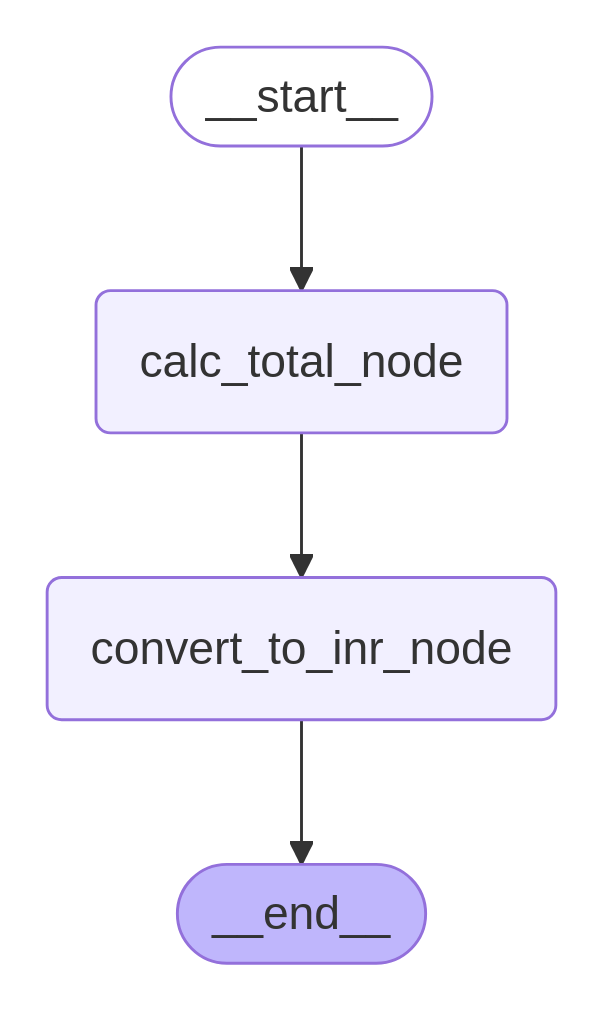

In [55]:
from langchain_core.runnables.graph_mermaid import MermaidDrawMethod
from IPython.display import Image, display

import nest_asyncio
nest_asyncio.apply()

# Use local browser rendering instead of external API
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

In [56]:
graph.invoke({"amount_usd": 100000})

{'amount_usd': 100000, 'total_usd': 108000.0, 'total_inr': 9180000.0}

## MY IMPLEMENTATION

In [57]:
from langgraph.graph import StateGraph, START, END

from typing import TypedDict, Literal

# her node'da kullanılan ve güncellenen state'i tanımlıyoruz
class State(TypedDict):
    amount_usd: float
    total_usd: float
    currency: Literal['TRY', 'EUR']
    total: float


def calc_total_usd(state: State) -> State:
    state['total_usd'] = state['amount_usd'] * 1.08
    return state

def calc_total(state: State) -> State:
    if state['currency'] == 'TRY':
        state['total'] = state['total_usd'] * 40
    elif state['currency'] == 'EUR':
        state['total'] = state['total_usd'] * 0.9
    else:
        raise ValueError("Unsupported currency")
    return state

def choose_currency(state: State) -> State:
    return state["currency"]

In [58]:
# şimdi node'ları tanımlıyoruz
builder = StateGraph(State)

builder.add_node("calc_total_node", calc_total_usd)
builder.add_node("convert_to_try_node", calc_total)
builder.add_node("convert_to_eur_node", calc_total)

# node'lar arasındaki geçişleri tanımlıyoruz
builder.add_edge(START, "calc_total_node")

builder.add_conditional_edges(
    "calc_total_node", 
    choose_currency,
    {
        "TRY": "convert_to_try_node",
        "EUR": "convert_to_eur_node"
    }
)

builder.add_edge(["convert_to_try_node", "convert_to_eur_node"], END)

# graph'ı derliyoruz
graph = builder.compile()


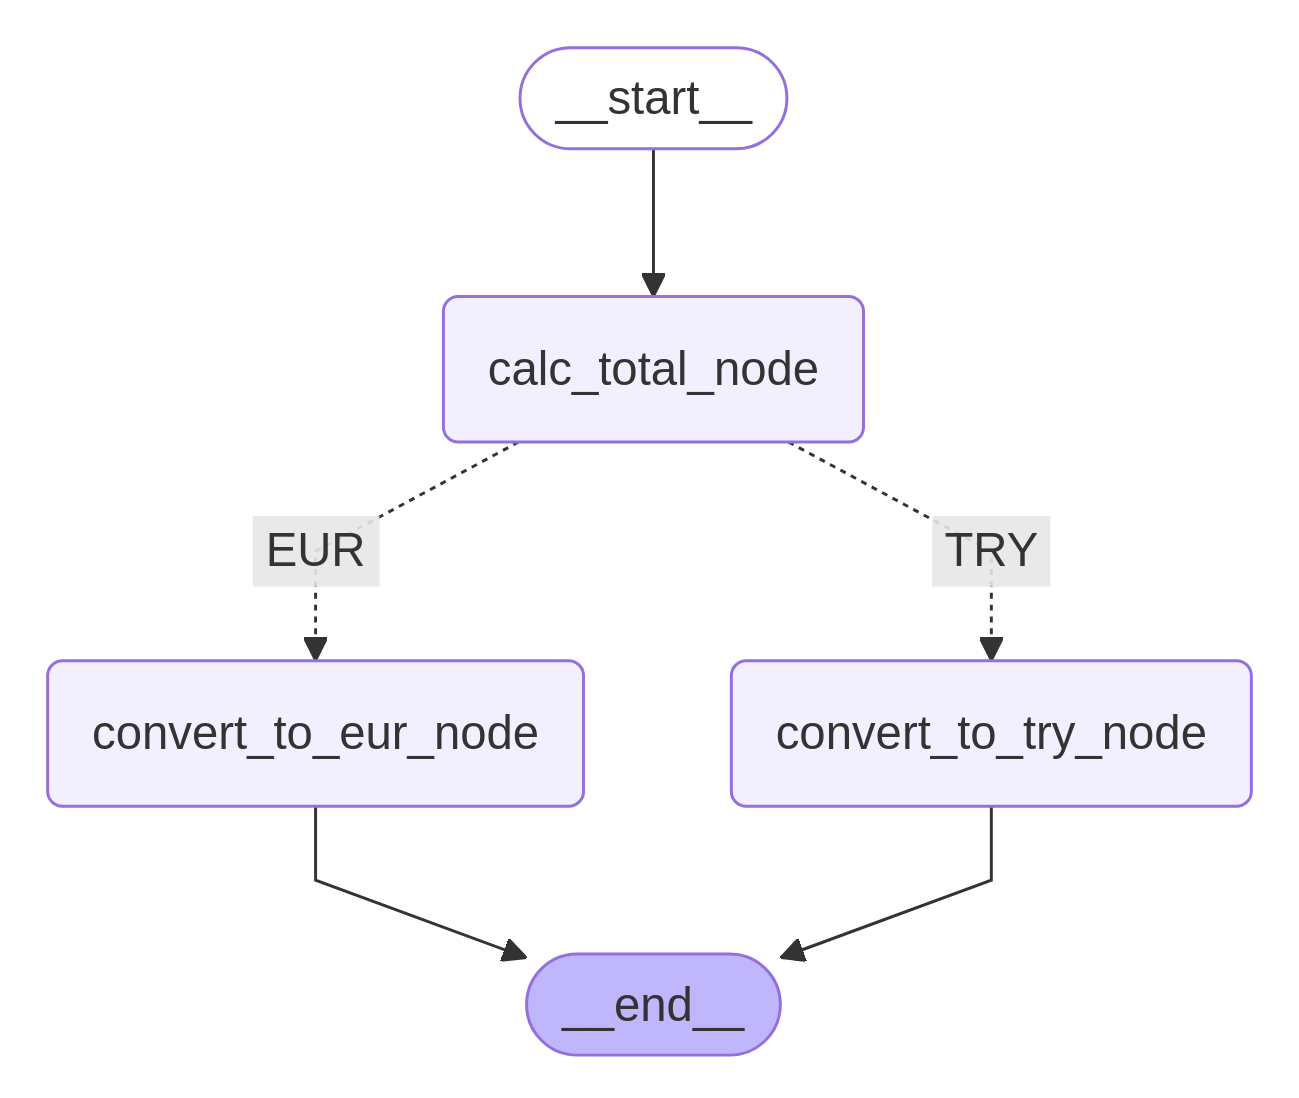

In [59]:

from langchain_core.runnables.graph_mermaid import MermaidDrawMethod
from IPython.display import Image, display

import nest_asyncio
nest_asyncio.apply()

# Use local browser rendering instead of external API
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))


In [60]:

# graph'ı çalıştırıyoruz
result = graph.invoke({"amount_usd": 100000, "currency": "TRY"})
print(result)

{'amount_usd': 100000, 'total_usd': 108000.0, 'currency': 'TRY', 'total': 4320000.0}
